## Descripción General
El objetivo de este proyecto es desarrollar un modelo de Machine Learning para predecir el resultado de partidos de basquetball basado en diversas características del juego y del equipo. El modelo final se utilizará para ayudar a los analistas deportivos a tomar decisiones informadas sobre el rendimiento de los equipos.

## Contexto
La industria del deporte utiliza cada vez más la analítica de datos para tomar decisiones estratégicas. Los modelos de predicción pueden ser útiles para pronósticos de partidos, análisis de jugadores y estrategias de juego. Este proyecto aborda el desafío de predecir el resultado de los partidos (ganar o perder) utilizando un conjunto de datos con características relevantes.

## Datos Utilizados
El conjunto de datos para este proyecto proviene de kaggle. Contiene información sobre varios aspectos del juego, incluyendo estadísticas del equipo, rendimiento de jugadores, y otros datos relevantes. La preparación de los datos incluyó la limpieza, transformación y selección de características importantes para el modelado.

## Objetivos
- Construir un modelo de clasificación basado en Random Forest para predecir el resultado de los partidos.
- Optimizar el modelo para mejorar su precisión y robustez.
- Evaluar el modelo utilizando métricas de rendimiento como precisión, recall y F1-score.


In [1]:
import pandas as pd
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

def get_info(df):

    print(df.info())
    display(df.head())
    print('\nValores null/isna')
    valores_ausentes =  df.isna().sum()
    display(valores_ausentes)

# Crear una función para seleccionar las variables correlacionadas(mitad de Abajo matriz)
def select_correlated_vars(correlation_matrix, threshold):
    var_correlation = []

    # Obtener los índices de la mitad inferior de la matriz de correlación
    lower_triangle_indices = np.tril_indices_from(correlation_matrix, -1)

    # Iterar sobre las columnas de la matriz de correlación
    for i, col in enumerate(correlation_matrix.columns):
        # Obtener los índices de las variables correlacionadas que superan el umbral
        correlated_indices = np.where((correlation_matrix[col].abs() > threshold) & (correlation_matrix[col].abs() < 1))[0]
        
        # Filtrar solo los índices de la mitad inferior de la matriz de correlación
        correlated_indices = correlated_indices[np.where(correlated_indices < i)]

        # Obtener los nombres de las variables correlacionadas
        correlated_vars = correlation_matrix.columns[correlated_indices].tolist()
        
        # Agregar las variables correlacionadas a la lista
        if correlated_vars:
            var_correlation.append((col, correlated_vars))

    return var_correlation

def correlation_matrx(df):
    #Procedemos a realiza una matriz de correlacion para las distintas variables
    # Escalamos las variables
    scaler = StandardScaler()
    scaled_data2 = scaler.fit_transform(df)

    # Calculamos la correlación
    correlation = np.corrcoef(scaled_data2, rowvar=False)

    # Convertimos el gráfico en una tabla
    correlation_df = pd.DataFrame(correlation, index=df.columns, columns=df.columns)

    # Solo mostramos las correlaciones con un valor absoluto superior a 0.6
    correlation_df1 = correlation_df[abs(correlation_df) > 0.6]

    # Imprimimos la tabla, Esta tabla ya esta sin los valores del treshhold, ya que fueron seleccionadas las variables mas arriba
    print(correlation_df1.to_string())

In [2]:
df = pd.read_csv('game1.csv', parse_dates=['game_date'])

In [3]:
df.columns

Index(['season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home',
       'game_id', 'game_date', 'matchup_home', 'wl_home', 'min', 'fgm_home',
       'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home',
       'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home',
       'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
       'pts_home', 'plus_minus_home', 'video_available_home', 'team_id_away',
       'team_abbreviation_away', 'team_name_away', 'matchup_away', 'wl_away',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'video_available_away',
       'season_type'],
      dtype='object')

In [4]:
#eliminamos las variables que no son de interes para el proyecto 
columnas_eliminar=['video_available_home','video_available_away','min','team_name_home','team_name_away','matchup_home','matchup_away','team_abbreviation_home', 'team_abbreviation_away','team_id_away','wl_away','plus_minus_home','plus_minus_away']

games=df.drop(columnas_eliminar, axis=1)
#Eliminamos la data que de los años que no nos interesan

games = games[(games['game_date'] >= '2010-01-01') & (games['game_date'] <= '2018-08-16')]



In [5]:
#eliminamos los valores vacios 
games= games.dropna()


In [6]:
#procedemos a Mapear las victorios y perdidas como 0 y 1, lo que luego seran nuestras variables Target
games['wl_home'] = games['wl_home'].map({'W': 1, 'L': 0})



In [7]:
#nos aseguramos que esten en las season de All-star y Pre Season
games = games[~games['season_type'].isin(['All-Star', 'Pre Season'])]


In [8]:
#Eliminamos estas variables ya qie nos molestan para ghacer el feature importance
games = games.drop(['game_date','season_type'], axis=1)

In [9]:
#hacemos las dummies de los equipos
games = pd.get_dummies(games, columns=['wl_home'], drop_first=True)


In [10]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9885 entries, 48459 to 59254
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season_id     9885 non-null   int64  
 1   team_id_home  9885 non-null   int64  
 2   game_id       9885 non-null   int64  
 3   fgm_home      9885 non-null   float64
 4   fga_home      9885 non-null   float64
 5   fg_pct_home   9885 non-null   float64
 6   fg3m_home     9885 non-null   float64
 7   fg3a_home     9885 non-null   float64
 8   fg3_pct_home  9885 non-null   float64
 9   ftm_home      9885 non-null   float64
 10  fta_home      9885 non-null   float64
 11  ft_pct_home   9885 non-null   float64
 12  oreb_home     9885 non-null   float64
 13  dreb_home     9885 non-null   float64
 14  reb_home      9885 non-null   float64
 15  ast_home      9885 non-null   float64
 16  stl_home      9885 non-null   float64
 17  blk_home      9885 non-null   float64
 18  tov_home      9885 non-

In [11]:
games.head()

,season_id,team_id_home,game_id,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,...,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,wl_home_1
48459,22009,1610612747,20900476,39.0,86.0,0.453,8.0,20.0,0.400,23.0,...,4.0,30.0,34.0,31.0,5.0,1.0,14.0,24.0,108.0,1
48460,22009,1610612737,20900474,46.0,100.0,0.460,7.0,27.0,0.259,9.0,...,10.0,36.0,46.0,25.0,5.0,2.0,16.0,16.0,112.0,0
48461,22009,1610612750,20900475,37.0,86.0,0.430,8.0,18.0,0.444,12.0,...,9.0,29.0,38.0,22.0,14.0,5.0,12.0,15.0,106.0,0
48462,22009,1610612764,20900480,35.0,80.0,0.438,4.0,10.0,0.400,12.0,...,3.0,34.0,37.0,23.0,3.0,3.0,12.0,24.0,97.0,0
48463,22009,1610612756,20900485,40.0,88.0,0.455,5.0,18.0,0.278,18.0,...,16.0,33.0,49.0,25.0,7.0,5.0,9.0,20.0,128.0,0


In [12]:
#realizamos en Feature Importance para saber con que variables nos quedamos

X = games.drop(['wl_home_1'],axis=1)
y = games['wl_home_1']


X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestClassifier(n_estimators=100)


model.fit(X1_train, y1_train)


importances = model.feature_importances_


threshold = 0.01


df_featureImportance1 = pd.DataFrame({'variable': X.columns, 'importance': importances})


df_important = df_featureImportance1[df_featureImportance1['importance'] > threshold]

df_important = df_important.sort_values('importance', ascending=True)


print("*Important Features (Importance > 0.01):*")
print(df_important)

*Important Features (Importance > 0.01):*
        variable  importance
18      tov_home    0.010378
19       pf_home    0.011635
37       pf_away    0.011918
6      fg3m_home    0.012560
24     fg3m_away    0.012807
32      reb_away    0.013325
14      reb_home    0.014365
28      fta_away    0.015143
10      fta_home    0.016219
27      ftm_away    0.019115
9       ftm_home    0.021678
8   fg3_pct_home    0.023113
15      ast_home    0.023485
33      ast_away    0.023728
13     dreb_home    0.024028
31     dreb_away    0.026614
26  fg3_pct_away    0.027984
3       fgm_home    0.046957
21      fgm_away    0.047479
5    fg_pct_home    0.071828
23   fg_pct_away    0.080145
20      pts_home    0.162824
38      pts_away    0.168839


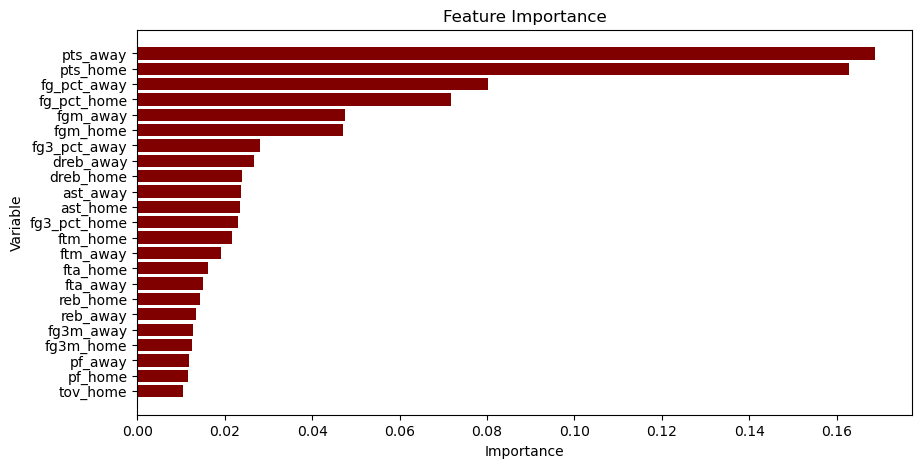

In [13]:
#Creamos un grafico con las varibales para poder visualizarlos mejor
fig = plt.figure(figsize=(10, 5))
 

plt.barh(df_important['variable'], df_important['importance'], color='maroon')
 
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Feature Importance")
plt.show()


In [14]:
#Guardamos las varibale  del feature importance en una lista

var_feature_Importance = df_important['variable'].to_list()

In [15]:
print(var_feature_Importance)

['tov_home', 'pf_home', 'pf_away', 'fg3m_home', 'fg3m_away', 'reb_away', 'reb_home', 'fta_away', 'fta_home', 'ftm_away', 'ftm_home', 'fg3_pct_home', 'ast_home', 'ast_away', 'dreb_home', 'dreb_away', 'fg3_pct_away', 'fgm_home', 'fgm_away', 'fg_pct_home', 'fg_pct_away', 'pts_home', 'pts_away']


In [16]:
#Procedemos a realiza una matriz de correlacion para las distintas variables


games_FI = games[var_feature_Importance]


scaler = StandardScaler()
scaled_data2 = scaler.fit_transform(games_FI)

correlation = np.corrcoef(scaled_data2, rowvar=False)


correlation_df = pd.DataFrame(correlation, index=games_FI.columns, columns=games_FI.columns)

#
correlation_df1 = correlation_df[abs(correlation_df) > 0.6]


print(correlation_df1.to_string())

              tov_home   pf_home   pf_away  fg3m_home  fg3m_away  reb_away  reb_home  fta_away  fta_home  ftm_away  ftm_home  fg3_pct_home  ast_home  ast_away  dreb_home  dreb_away  fg3_pct_away  fgm_home  fgm_away  fg_pct_home  fg_pct_away  pts_home  pts_away
tov_home           1.0       NaN       NaN        NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN           NaN       NaN       NaN        NaN        NaN           NaN       NaN       NaN          NaN          NaN       NaN       NaN
pf_home            NaN  1.000000       NaN        NaN        NaN       NaN       NaN  0.792719       NaN  0.726001       NaN           NaN       NaN       NaN        NaN        NaN           NaN       NaN       NaN          NaN          NaN       NaN       NaN
pf_away            NaN       NaN  1.000000        NaN        NaN       NaN       NaN       NaN  0.801724       NaN  0.734566           NaN       NaN       NaN        NaN        NaN           NaN       NaN       NaN   

In [17]:
#procedemos a reconocer y guardar las variables correlacionadas


umbral = 0.6


var_correlation = select_correlated_vars(correlation_df1, umbral)


print("Variables con correlación superior a 0.6 y menos a 1:")
for var, correlated in var_correlation:
    print(f"{var}: {correlated}")


Variables con correlación superior a 0.6 y menos a 1:
fta_away: ['pf_home']
fta_home: ['pf_away']
ftm_away: ['pf_home', 'fta_away']
ftm_home: ['pf_away', 'fta_home']
fg3_pct_home: ['fg3m_home']
dreb_home: ['reb_home']
dreb_away: ['reb_away']
fg3_pct_away: ['fg3m_away']
fgm_home: ['ast_home']
fgm_away: ['ast_away']
fg_pct_home: ['dreb_away', 'fgm_home']
fg_pct_away: ['dreb_home', 'fgm_away']
pts_home: ['fgm_home', 'fg_pct_home']
pts_away: ['fgm_away', 'fg_pct_away']


In [18]:
# Crear una lista temporal para almacenar todas las variables correlacionadas
all_correlated_vars = []


for _, correlated_vars in var_correlation:
    
    all_correlated_vars.extend(correlated_vars)


var_correlation_unique = np.unique(all_correlated_vars)




In [19]:
var_feature_Importance.append('wl_home_1')

In [20]:
print(var_correlation_unique)

['ast_away' 'ast_home' 'dreb_away' 'dreb_home' 'fg3m_away' 'fg3m_home'
 'fg_pct_away' 'fg_pct_home' 'fgm_away' 'fgm_home' 'fta_away' 'fta_home'
 'pf_away' 'pf_home' 'reb_away' 'reb_home']


In [21]:
print(var_feature_Importance)

['tov_home', 'pf_home', 'pf_away', 'fg3m_home', 'fg3m_away', 'reb_away', 'reb_home', 'fta_away', 'fta_home', 'ftm_away', 'ftm_home', 'fg3_pct_home', 'ast_home', 'ast_away', 'dreb_home', 'dreb_away', 'fg3_pct_away', 'fgm_home', 'fgm_away', 'fg_pct_home', 'fg_pct_away', 'pts_home', 'pts_away', 'wl_home_1']


In [22]:
#procedemos da dejar la la base de datos para entrenarlos con el VIF

games_FI = games[var_feature_Importance]
games_CM = games_FI.drop(var_correlation_unique, axis=1)

In [23]:
games_FI.columns

Index(['tov_home', 'pf_home', 'pf_away', 'fg3m_home', 'fg3m_away', 'reb_away',
       'reb_home', 'fta_away', 'fta_home', 'ftm_away', 'ftm_home',
       'fg3_pct_home', 'ast_home', 'ast_away', 'dreb_home', 'dreb_away',
       'fg3_pct_away', 'fgm_home', 'fgm_away', 'fg_pct_home', 'fg_pct_away',
       'pts_home', 'pts_away', 'wl_home_1'],
      dtype='object')

In [24]:
games_CM.columns

Index(['tov_home', 'ftm_away', 'ftm_home', 'fg3_pct_home', 'fg3_pct_away',
       'pts_home', 'pts_away', 'wl_home_1'],
      dtype='object')

In [25]:

# Escalamos las variables
scaler_VIF2 = StandardScaler()
scaled_data_VIF2 = scaler_VIF2.fit_transform(games_CM)


correlation_matrix_VIF2 = np.corrcoef(scaled_data_VIF2, rowvar=False)


vif2 = [variance_inflation_factor(correlation_matrix_VIF2, i) for i in range(correlation_matrix_VIF2.shape[0])]
tolerance2 = [1 / v for v in vif2]  


results_df = pd.DataFrame({
    "Variable": games_CM.columns,
    "VIF": vif2,
    "Tolerancia": tolerance2
})

# Mostrar los resultados
print(results_df)


       Variable        VIF  Tolerancia
0      tov_home   1.188898    0.841115
1      ftm_away   2.059568    0.485539
2      ftm_home   2.025936    0.493599
3  fg3_pct_home   3.298588    0.303160
4  fg3_pct_away   3.244592    0.308205
5      pts_home  33.074481    0.030235
6      pts_away  34.006262    0.029406
7     wl_home_1  27.419664    0.036470


In [26]:
print(results_df.sort_values('VIF', ascending=True))

       Variable        VIF  Tolerancia
0      tov_home   1.188898    0.841115
2      ftm_home   2.025936    0.493599
1      ftm_away   2.059568    0.485539
4  fg3_pct_away   3.244592    0.308205
3  fg3_pct_home   3.298588    0.303160
7     wl_home_1  27.419664    0.036470
5      pts_home  33.074481    0.030235
6      pts_away  34.006262    0.029406


AL realizar el analisis VIF dentro de la base de datos con bas bases con Feature Importance y Correlacion,quedan muy pocad variables para poder entregarle al modelos, por lo que no incluiremos.

In [27]:
games_final = games_CM

In [28]:
#procedemos a realizar una regresion como primera opcion

X = games_final.drop('wl_home_1',axis=1)
y = games_final['wl_home_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

model = LinearRegression() 
model.fit(X_train, y_train) 
predictions = model.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Coefficient of Determination (R^2):", r2)


print("\nAlgunas predicciones:")
for i in range(5):  
    print("Predicción:", predictions[i], "\tValor real:", y_test.iloc[i])


Mean Squared Error (MSE): 0.08433028221652952
Mean Absolute Error (MAE): 0.24938608944274598
Coefficient of Determination (R^2): 0.6503935437556292

Algunas predicciones:
Predicción: 1.2202264607154032 	Valor real: 1
Predicción: 0.271902221134076 	Valor real: 0
Predicción: 0.7768998928649069 	Valor real: 1
Predicción: -0.07027749212875078 	Valor real: 0
Predicción: 0.8406048361377472 	Valor real: 1


In [30]:
#con la regeesion nos da un r2 de 0,65, lo que no es muy bueno.

#por lo que procedemos a realizar un ramdom fores  y sus variaciones

X_RF = games_final.drop(['wl_home_1'], axis=1)
y_RF = games_final.wl_home_1


X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, test_size=0.3, random_state=2023)

bosque = RandomForestClassifier(n_estimators=100,
                              criterion="gini",  
                              max_features="sqrt",
                              random_state=2023,
                              bootstrap=True,
                              max_samples=2/3,
                              oob_score=True,  
                              min_samples_leaf=8)


bosque.fit(X_train_RF, y_train_RF)


y_pred_RF = bosque.predict(X_test_RF)


accuracy = accuracy_score(y_test_RF, y_pred_RF)
precision = precision_score(y_test_RF, y_pred_RF)
recall = recall_score(y_test_RF, y_pred_RF)
f1 = f1_score(y_test_RF, y_pred_RF)


print("Rendimiento del modelo con variables de interés:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Rendimiento del modelo con variables de interés:
Accuracy: 0.9821308159136884
Precision: 0.9808558558558559
Recall: 0.9892106757524134
F1-score: 0.985015549901046


In [31]:
#procedemos a realizar un randomized search para ver los mejore hiperparametros disponibles
from scipy.stats import randint


param_dist = {
    'n_estimators': randint(10, 200), 
    'criterion':['gini','entropy','log_loss'],  
    'max_depth': [None] + list(randint(3, 20).rvs(5)),  
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20),  
    'max_features': ['sqrt', 'log2', 'auto']  
}

rf = RandomForestClassifier(random_state=2023)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=2023)

random_search.fit(X_train_RF, y_train_RF)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters found:", best_params)
print("Best cross-validation score:", best_score)


/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
155 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
155 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.

Best parameters found: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 90}
Best cross-validation score: 0.9874265962826895


In [32]:
#Procedemos a ajustar ajustar esos hiperparametros, para ver el nuevo rendimeinto.

bosque_RS = RandomForestClassifier(n_estimators=90,
                            criterion="gini",  
                            max_depth=16,
                            max_features="log2",
                            random_state=2023,
                            bootstrap=True,
                            max_samples=2/3,
                            oob_score=True,  
                            min_samples_leaf=1,
                            min_samples_split= 4,
                            )


bosque_RS.fit(X_train_RF, y_train_RF)


y_pred_RF_RS = bosque_RS.predict(X_test_RF)

accuracy_RS = accuracy_score(y_test_RF, y_pred_RF_RS)
precision_RS = precision_score(y_test_RF, y_pred_RF_RS)
recall_RS = recall_score(y_test_RF, y_pred_RF_RS)
f1_RS = f1_score(y_test_RF, y_pred_RF_RS)

# Imprime las métricas
print("Rendimiento del modelo con variables de interés:")
print("Accuracy:", accuracy_RS)
print("Precision:", precision_RS)
print("Recall:", recall_RS)
print("F1-score:", f1_RS)

Rendimiento del modelo con variables de interés:
Accuracy: 0.9888739042481457
Precision: 0.9892412231030577
Recall: 0.9920499716070414
F1-score: 0.9906436064644173


In [33]:
#ahora procedemos a realizar el grid serach de las variables de interes uqe nos dieron el en Random Search
    
param_grid_discreto = {
    'n_estimators': [90, 100, 110],
    'criterion': ['gini', 'entropy'],
    'max_depth': [16, 18, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 'log2', 'auto'],
    'bootstrap': [True, False],
    'max_samples': [None, 0.5, 0.7],
    'oob_score': [True, False],
    'random_state': [2023]

}

rf_grid_discreto = RandomForestClassifier()

grid_search_discreto = GridSearchCV(estimator=rf_grid_discreto, param_grid=param_grid_discreto, cv=5, n_jobs=-1)

grid_search_discreto.fit(X_train_RF, y_train_RF)

best_params_grid_discreto = grid_search_discreto.best_params_
best_score_grid_discreto = grid_search_discreto.best_score_

print("Best parameters found with Grid Search:", best_params_grid_discreto)
print("Best cross-validation score with Grid Search:", best_score_grid_discreto)


/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5940 fits failed out of a total of 9720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1757 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/pytho

Best parameters found with Grid Search: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True, 'random_state': 2023}
Best cross-validation score with Grid Search: 0.9907501912153774


In [34]:
#ahora procedemos a realizar el ultimo modelo con los hiperparamedtros del Gris Search para ver el nnuevo rendimiento del modelo

bosque_GS_discreto = RandomForestClassifier(n_estimators=110,
                            criterion="gini",  
                            max_depth=20,
                            max_features="sqrt",
                            random_state=2023,
                            bootstrap=True,
                            max_samples=0.7,
                            oob_score=True, 
                            min_samples_leaf=1,
                            min_samples_split= 2,
                            )


bosque_GS_discreto.fit(X_train_RF, y_train_RF)


y_pred_RF_RS_GS = bosque_GS_discreto.predict(X_test_RF)

accuracy_GS_discreto = accuracy_score(y_test_RF, y_pred_RF_RS_GS)
precision_GS_discreto = precision_score(y_test_RF, y_pred_RF_RS_GS)
recall_GS_discreto = recall_score(y_test_RF, y_pred_RF_RS_GS)
f1_GS_discreto = f1_score(y_test_RF, y_pred_RF_RS_GS)

# Imprime las métricas
print("Rendimiento del modelo con variables de interés:")
print("Accuracy:", accuracy_GS_discreto)
print("Precision:", precision_GS_discreto)
print("Recall:", recall_GS_discreto)
print("F1-score:", f1_GS_discreto)

Rendimiento del modelo con variables de interés:
Accuracy: 0.9881995954146999
Precision: 0.9864712514092446
Recall: 0.9937535491198183
F1-score: 0.9900990099009901


In [35]:
#ahora procedemomos a generar el grid search con valores continuos

param_grid_continuo = {
    'n_estimators': list(range(90, 120, 10)),  
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(14, 22, 2)),  
    'min_samples_split': list(range(2, 8, 2)),
    'min_samples_leaf': list(range(1, 4)),  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False],
    'max_samples': np.linspace(0.4, 0.7, 4),  
    'random_state': [2023]
}

rf_grid = RandomForestClassifier()

grid_search_continuo = GridSearchCV(estimator=rf_grid, param_grid=param_grid_continuo, cv=5, n_jobs=-1)  

grid_search_continuo.fit(X_train_RF, y_train_RF)

best_params_grid_continuo = grid_search_continuo.best_params_
best_score_grid_continuo = grid_search_continuo.best_score_

print("Best parameters found with Grid Search:", best_params_grid_continuo)
print("Best cross-validation score with Grid Search:", best_score_grid_continuo)

/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
8640 fits failed out of a total of 17280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8640 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/raimundoschulzehot/miniconda3/envs/diplomado/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/raimundoschulzehot/miniconda3/envs/d

Best parameters found with Grid Search: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110, 'random_state': 2023}
Best cross-validation score with Grid Search: 0.9888717874771691


Con estos hiperparametros ya definidos, podemos decir que le modelo para prediccion de los resultados de la NBA tienie una accurracy de 0.99

Para continuar, procedemos a realiza la matriz de correlacion y agrergar los distintos valores a la tabla de predicciones.

In [36]:
#ahora procedemos a realizar el ultimo modelo con los hiperparamedtros del Gris Sdarch continiuo para ver el nnuevo rendimoento del modelo

bosque_GS_continuo = RandomForestClassifier(n_estimators=110,
                            criterion="gini",  
                            max_depth=18,
                            max_features="sqrt",
                            random_state=2023,
                            bootstrap=True,
                            max_samples=0.7,
                            oob_score=True,  
                            min_samples_leaf=1,
                            min_samples_split= 10,
                            )


bosque_GS_continuo.fit(X_train_RF, y_train_RF)


y_pred_RF_RS_GS_continuo = bosque_GS_continuo.predict(X_test_RF)

accuracy_GS_continuo = accuracy_score(y_test_RF, y_pred_RF_RS_GS_continuo)
precision_GS_continuo = precision_score(y_test_RF, y_pred_RF_RS_GS_continuo)
recall_GS_continuo = recall_score(y_test_RF, y_pred_RF_RS_GS_continuo)
f1_GS_continuo = f1_score(y_test_RF, y_pred_RF_RS_GS_continuo)

# Imprime las métricas
print("Rendimiento del modelo con variables de interés:")
print("Accuracy:", accuracy_GS_continuo)
print("Precision:", precision_GS_continuo)
print("Recall:", recall_GS_continuo)
print("F1-score:", f1_GS_continuo)

Rendimiento del modelo con variables de interés:
Accuracy: 0.9871881321645314
Precision: 0.9853521126760564
Recall: 0.9931856899488927
F1-score: 0.9892533936651584


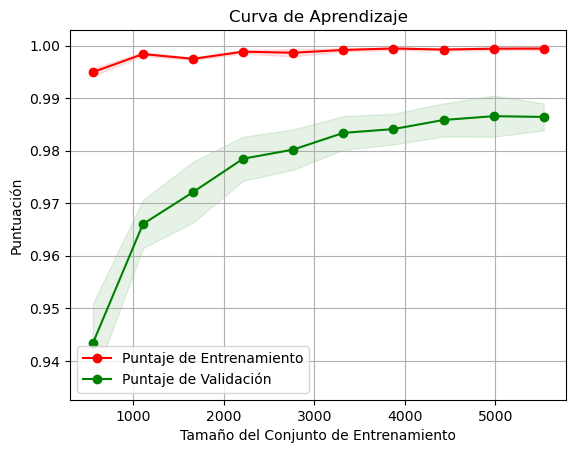

In [37]:
#procedemos a ver distintas curvas para generar otras formas de validacion

#partiremos con una curva de aprendizaje

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np


train_sizes, train_scores, valid_scores = learning_curve(
    bosque_GS_continuo, X_train_RF, y_train_RF, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


plt.figure()
plt.title("Curva de Aprendizaje")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Puntuación")
plt.grid()


plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Puntaje de Entrenamiento")


plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label="Puntaje de Validación")


plt.legend(loc="best")
plt.show()
